4\. Assignment: Create a customer segmentation
----------------------------------------------------

### Objective

The goal of this assignment is to segment a credit card customer base into different groups for marketing and customer management purposes.


### **(I)**  **Load and Explore the Data:** 

### **Load the data**
- See the first few rows of the dataset (.head()),
- Understand the structure and data types (.info()),
- And get descriptive statistics (.describe()).

In [97]:
python_material_folder_name = "python-material"

In [98]:
# Import necessary libraries
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Check if in Google Colab environment
try:
    from google.colab import drive
    # Mount drive
    drive.mount('/content/drive')
    # Set up path to Python material parent folder
    path_python_material = rf"drive/MyDrive/{python_material_folder_name}"
        # If unsure, print current directory path by executing the following in a new cell:
        # !pwd
    IN_COLAB = True
except:
    IN_COLAB = False
    # If working locally on Jupyter Notebook, parent folder is one folder up (assuming you are using the folder structure shared at the beginning of the course)
    path_python_material = ".."

In [99]:
# Read data that was exported from previous session
df = pd.read_csv(f"{path_python_material}/data/1-raw/dsif8-assignment/customer_data.csv")


In [100]:
# Inspect the first few rows
print("Dataset Head:")
print(df.head())

# Check dataset info
print("\nDataset Info:")
print(df.info())

# Get summary statistics
print("\nSummary Statistics:")
print(df.describe())

Dataset Head:
  CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONE_OFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40               0.00   
1  C10002  3202.467416           0.909091       0.00               0.00   
2  C10003  2495.148862           1.000000     773.17             773.17   
3  C10004  1666.670542           0.636364    1499.00            1499.00   
4  C10005   817.714335           1.000000      16.00              16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONE_OFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                     0.000000                          0.083333   
1             

## Visualizing Distributions and Relationships

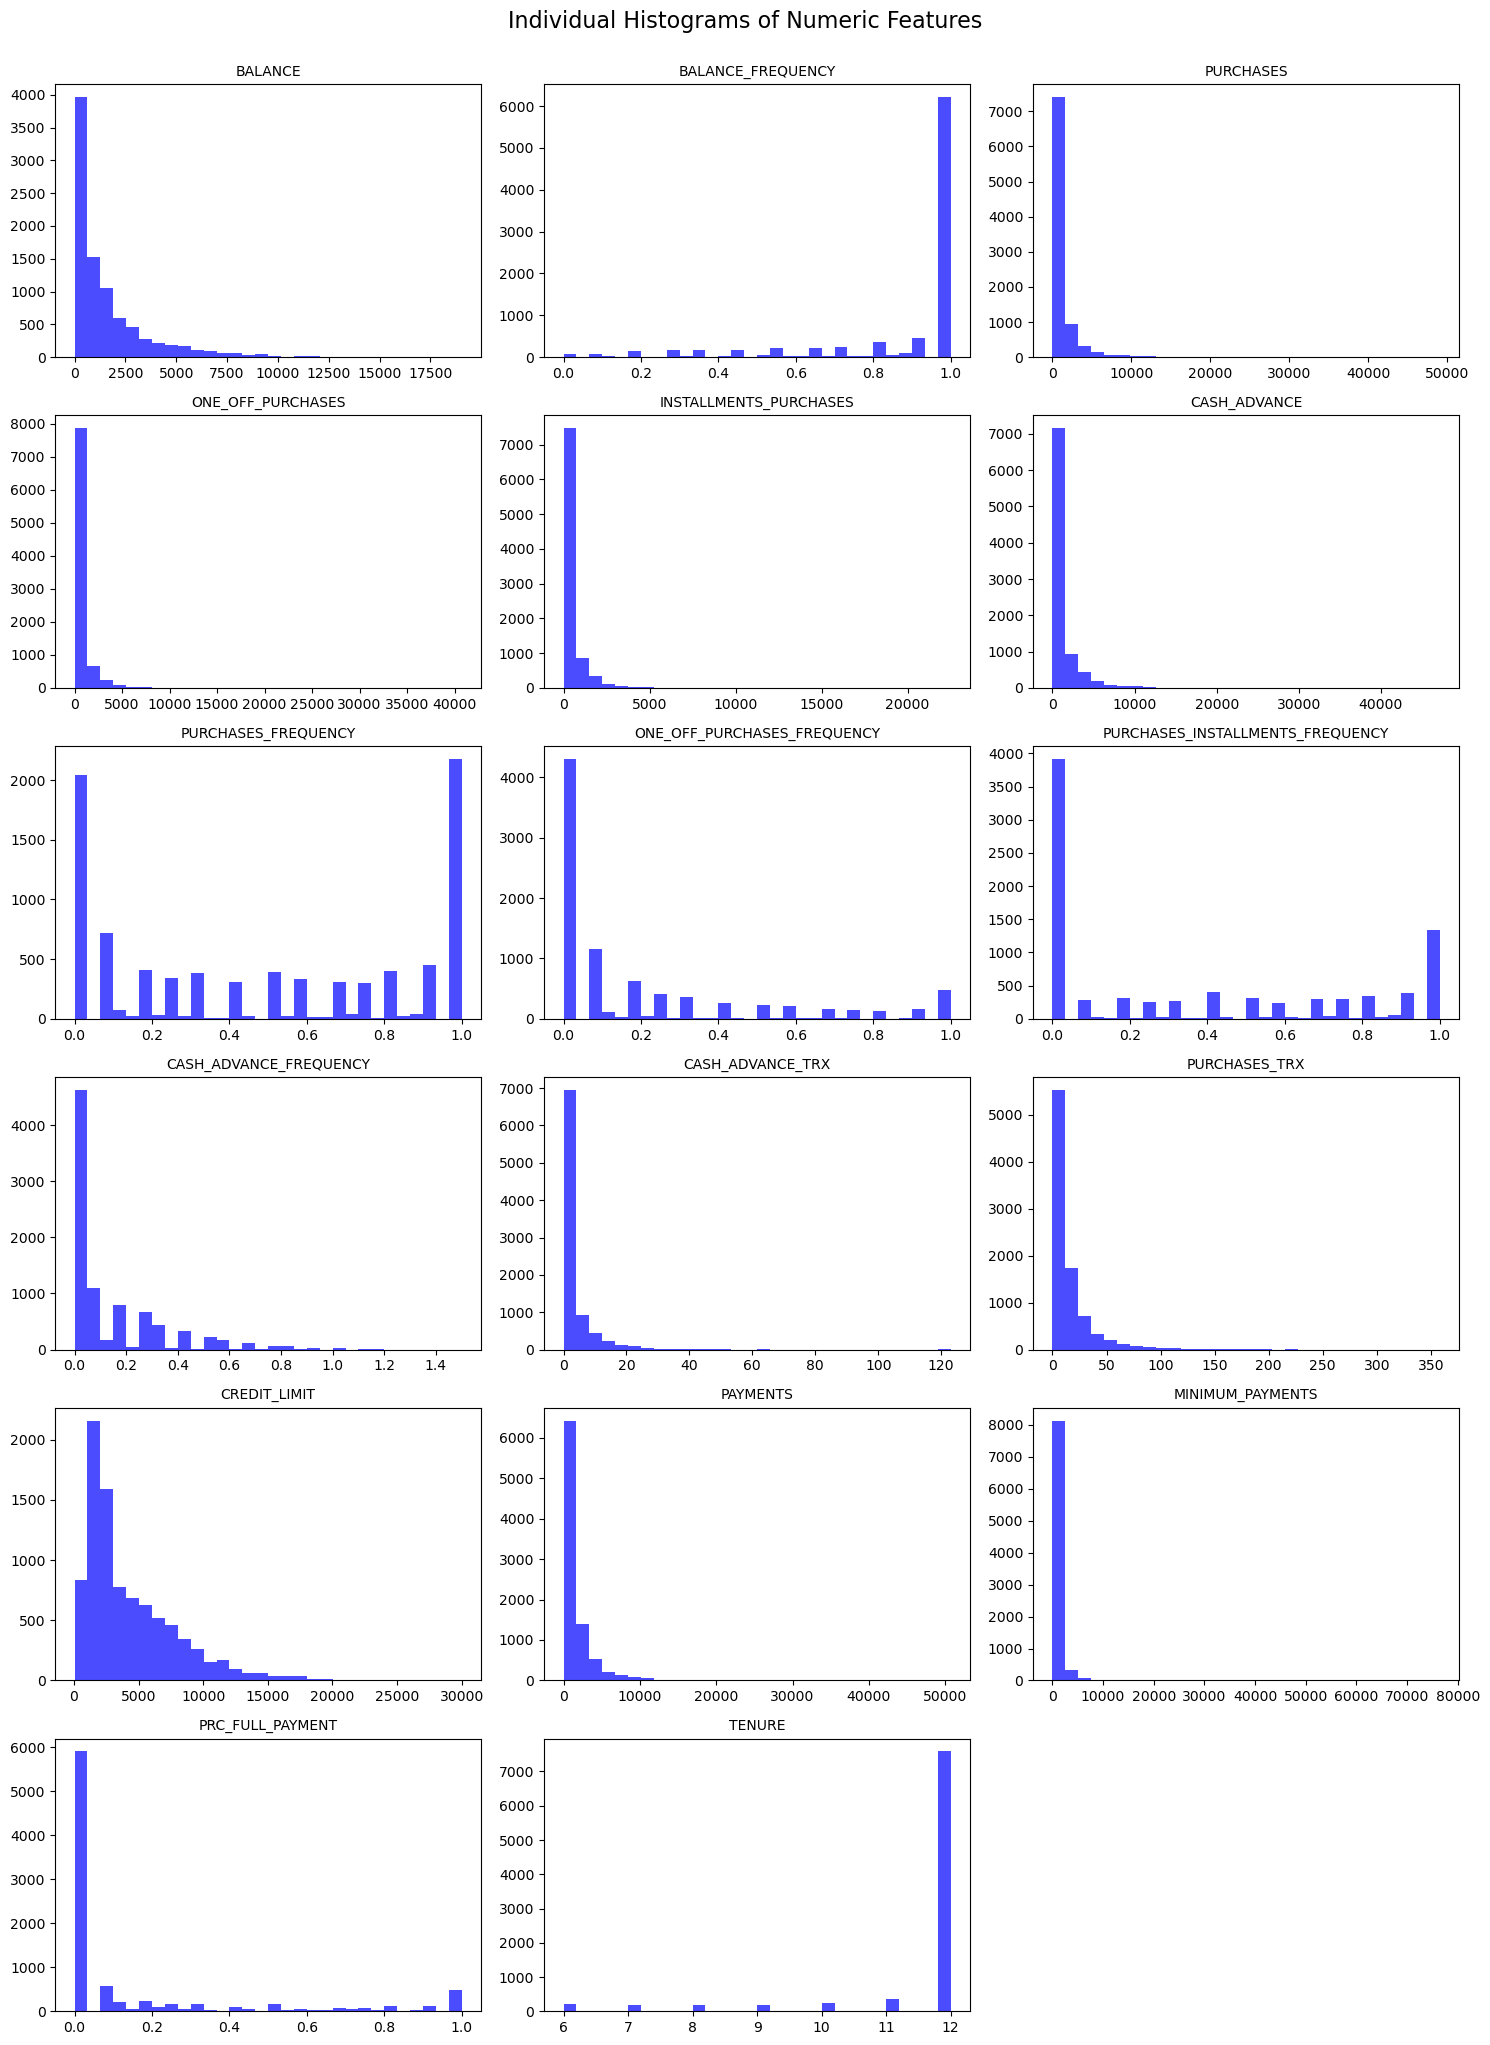

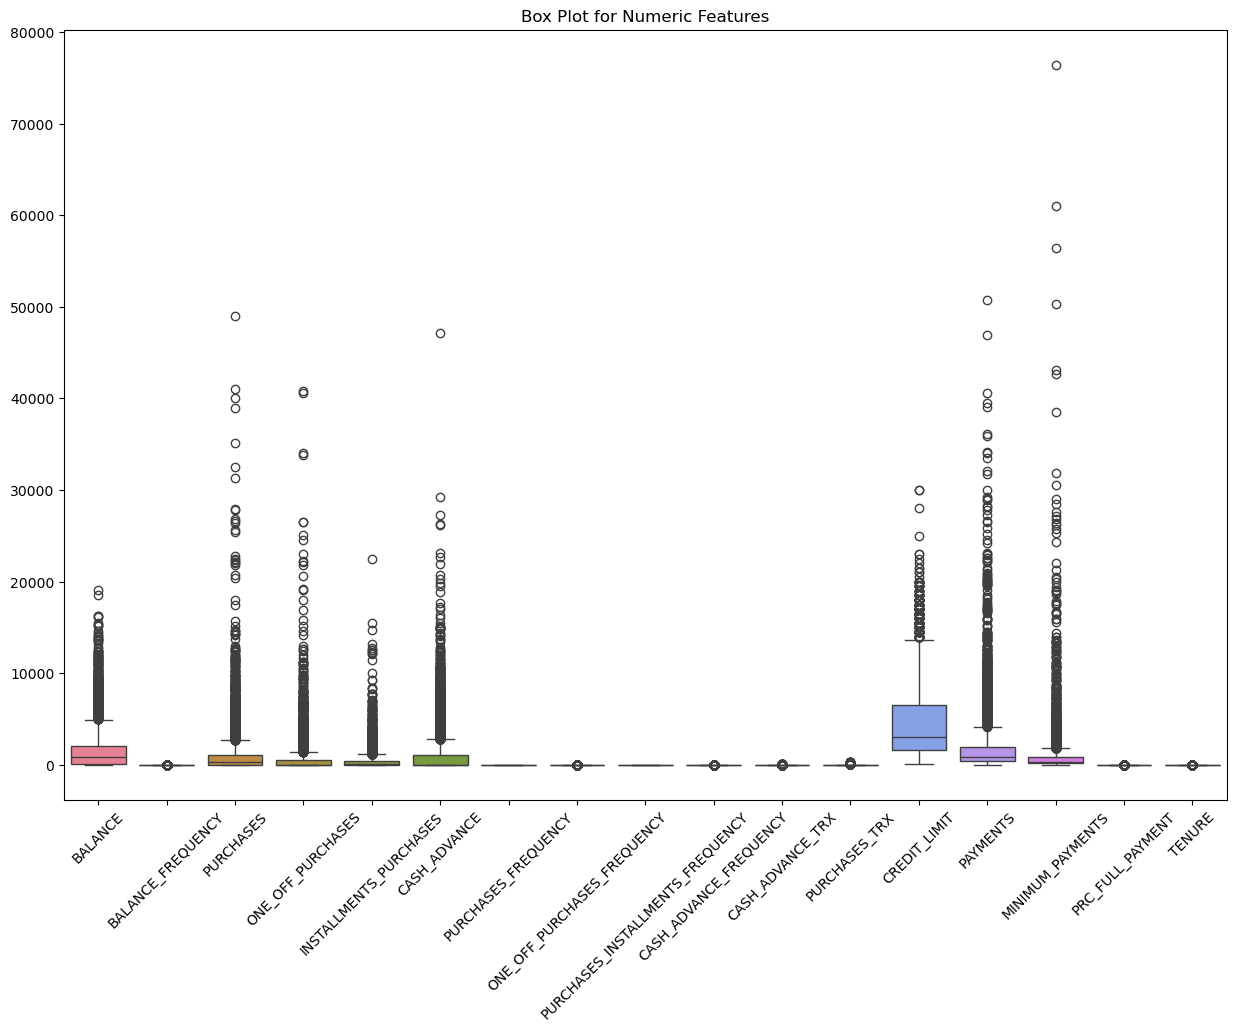

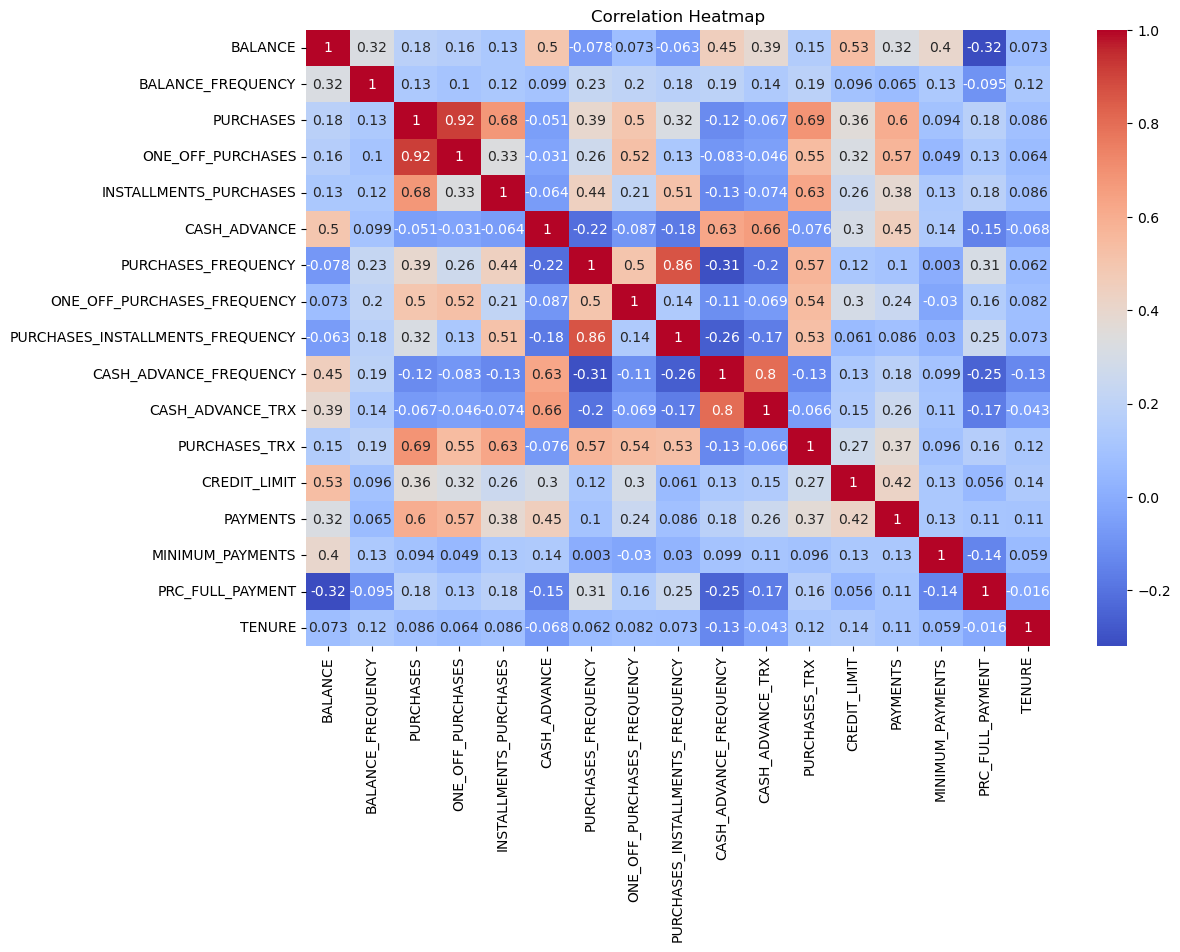

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for each numeric column
numeric_columns = df.select_dtypes(include=['number']).columns

plt.figure(figsize=(15, 20))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(6, 3, i)  # Adjust the grid size based on the number of columns
    plt.hist(df[column], bins=30, alpha=0.7, color='blue')
    plt.title(column, fontsize=10)
    plt.tight_layout()

plt.suptitle('Individual Histograms of Numeric Features', y=1.02, fontsize=16)
plt.show()

# Box plot for outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=df.iloc[:, 1:])  # Exclude CUST_ID
plt.title('Box Plot for Numeric Features')
plt.xticks(rotation=45)
plt.show()

# Exclude non-numeric columns like 'CUST_ID'
numeric_df = df.select_dtypes(include=['number'])

# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [103]:
from scipy.stats import zscore

# Calculate Z-Scores for all numeric columns
z_scores = df[numeric_columns].apply(zscore)

# Identify rows with outliers (absolute Z-Score > 3)
outliers = (z_scores.abs() > 3).any(axis=1)
print(f"Number of outliers: {outliers.sum()}")
df_outliers = df[outliers]

# Calculate IQR for each column
Q1 = df[numeric_columns].quantile(0.25)
Q3 = df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers_iqr = ((df[numeric_columns] < (Q1 - 1.5 * IQR)) | 
                (df[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)
print(f"Number of outliers: {outliers_iqr.sum()}")
df_outliers_iqr = df[outliers_iqr]


Number of outliers: 1376
Number of outliers: 5956


## EDA Summary:
1. Data Summary
- Customer Distribution:
- Total customers: 8950.
- Unique identifier (CUST_ID) confirms no duplicates for IDs.

**Feature Insights:**

Columns like BALANCE, PURCHASES, and CASH_ADVANCE show substantial variability, with high means and standard deviations indicating diverse financial behaviors.

Missing Values: CREDIT_LIMIT: 1 missing value.

MINIMUM_PAYMENTS: 313 missing values.

Action: We'll need to handle these missing values in preprocessing (imputation or removal).

2. Key Distributions (Skewness Analysis)
- Many features (e.g., PURCHASES, CASH_ADVANCE, MINIMUM_PAYMENTS) exhibit strong positive skewness. This implies: Majority of values are relatively low.
- A small group of customers displays extreme behavior (e.g., heavy spending or large payments).
- Log Transformation might help reduce the impact of outliers during clustering.

3. Outliers
- 1376 outliers detected using Z-Score.
- 5956 outliers detected using IQR.

Key features with many outliers: BALANCE, PURCHASES, CASH_ADVANCE, and MINIMUM_PAYMENTS.

Action: Retain or cap extreme outliers, depending on their relevance to customer segmentation.

4. Correlation Heatmap Insights
- From the heatmap (if already reviewed):

**Strong correlations:**

PURCHASES ↔ ONE_OFF_PURCHASES & INSTALLMENTS_PURCHASES: Reflects customer spending trends.

CREDIT_LIMIT ↔ PAYMENTS: Likely indicative of higher credit limits facilitating larger payments.

**Weak correlations:**

Between BALANCE and frequency columns (e.g., BALANCE_FREQUENCY).

Implication: Spending habits seem independent of balance frequency.

In [105]:
# Handle missing values
df['MINIMUM_PAYMENTS'] = df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median())
df = df.dropna(subset=['CREDIT_LIMIT'])

# List of skewed columns to transform (you can add more if needed)
skewed_columns = ['BALANCE', 'PURCHASES', 'ONE_OFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 
                  'CASH_ADVANCE', 'MINIMUM_PAYMENTS']

print("Missing values handled.")

# Apply log transformation (log(1 + x) to handle zeros)
for col in skewed_columns:
    df[col] = df[col].apply(lambda x: np.log1p(x))

print("Skewed features transformed.")

# Calculate IQR bounds for capping outliers
Q1 = df[numeric_columns].quantile(0.25)
Q3 = df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# Cap values outside the bounds
df[numeric_columns] = df[numeric_columns].clip(lower=(Q1 - 1.5 * IQR), upper=(Q3 + 1.5 * IQR), axis=1)

print("Outliers capped.")

from sklearn.preprocessing import StandardScaler

# Normalize numerical columns
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

print("Features normalized.")


Missing values handled.
Skewed features transformed.
Outliers capped.
Features normalized.


## Clustering Process
1. **Reduce Dimensions (Optional):**
- Use Principal Component Analysis (PCA) to reduce dimensions for better clustering performance if the dataset is high-dimensional.
- This also helps visualize clusters in 2D or 3D.

2. **Apply K-Means Clustering:**
- Identify the optimal number of clusters using methods like the Elbow method.
- Apply K-Means to segment the data.

3. **Visualize Clusters (Optional for 2D/3D data):**
- If PCA is used, plot the clusters to understand their separation.



In [107]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2 for visualization
pca = PCA(n_components=2)  # Reduce to 2 components
df_pca = pca.fit_transform(df.select_dtypes(include=['number']))

print("Explained Variance Ratios:", pca.explained_variance_ratio_)


Explained Variance Ratios: [0.34485074 0.23997025]


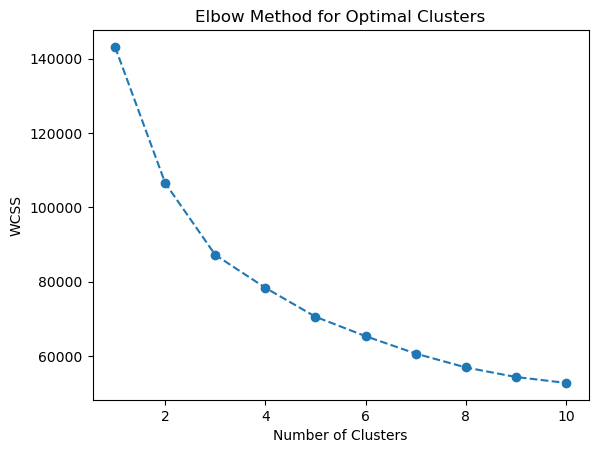

In [108]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method to find optimal clusters
wcss = []
for i in range(1, 11):  # Test clusters 1-10
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df.select_dtypes(include=['number']))  # Fit numeric data
    wcss.append(kmeans.inertia_)  # Append WCSS value

# Plot the Elbow Curve
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


In [109]:
# Apply K-Means with the chosen number of clusters (e.g., k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df.select_dtypes(include=['number']))

print("Cluster Labels Assigned:", df['Cluster'].unique())


Cluster Labels Assigned: [2 0 1]


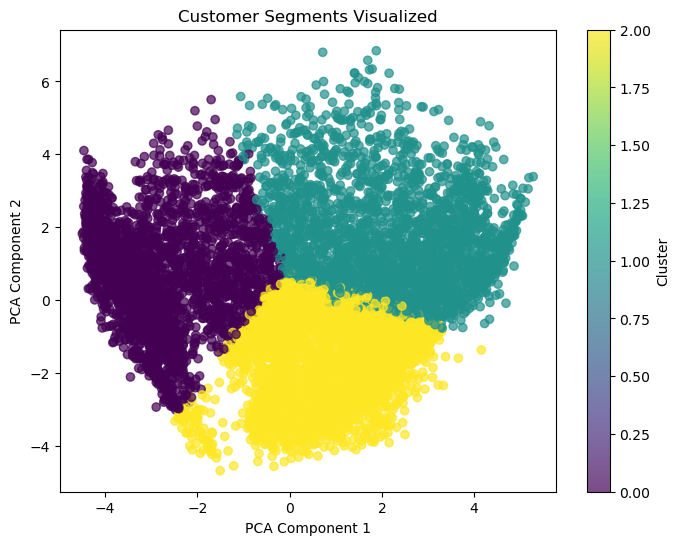

In [110]:
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df['Cluster'], cmap='viridis', alpha=0.7)
plt.title('Customer Segments Visualized')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [111]:
# Group by clusters and calculate the mean for numeric features only
numeric_columns = df.select_dtypes(include=['number']).columns
cluster_profiles = df.groupby('Cluster')[numeric_columns].mean()

# Leave 'Cluster' as the index
print("Cluster Profiles Summary:\n", cluster_profiles)


Cluster Profiles Summary:
           BALANCE  BALANCE_FREQUENCY  PURCHASES  ONE_OFF_PURCHASES  \
Cluster                                                              
0        0.570638           0.167377  -1.037844          -0.540235   
1        0.473420           0.487343   0.891545           0.939205   
2       -0.853537          -0.507073   0.261292          -0.213998   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster                                                              
0                     -0.877263      1.009573            -0.974989   
1                      0.766308     -0.147986             0.982692   
2                      0.211503     -0.784044             0.138546   

         ONE_OFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
Cluster                                                                  
0                          -0.522023                         -0.803984   
1                           1.077672             

# Cluster Analysis and Segmentation

### Here’s how we can profile the clusters based on their characteristics:

---

## **Cluster 0: High Cash Advance Users**

### **Key Traits:**
- **High Cash Advances:** Both `CASH_ADVANCE` and `CASH_ADVANCE_FREQUENCY` are significantly above average (positive values).
- **Low Purchases:** `PURCHASES` and `PURCHASES_FREQUENCY` are well below the average.
- **Moderate Credit Use:** `CREDIT_LIMIT` is near the overall mean, and `MINIMUM_PAYMENTS` are slightly higher than the median.
- Likely represents customers who rely on cash advances rather than credit for purchases.

### **Potential Strategies:**
- Introduce cash advance fee reduction programs to incentivize loyalty.
- Offer educational content on managing finances and transitioning to credit-based spending.
- Promote products with minimal fees or cashback rewards to encourage more purchases.

---

## **Cluster 1: Active Spenders**

### **Key Traits:**
- **High Purchases:** Significant positive values in `PURCHASES` and `PURCHASES_FREQUENCY`. Both `ONE_OFF_PURCHASES` and `INSTALLMENTS_PURCHASES` are strong, reflecting diverse spending habits.
- **Good Credit Behavior:** `CREDIT_LIMIT` and `PAYMENTS` are above average, indicating financial capability and reliable repayments.
- This group represents premium or high-value customers who frequently use their credit accounts.

### **Potential Strategies:**
- Tailor premium rewards programs or exclusive offers to this cluster.
- Introduce higher credit limits and personalized services to strengthen retention.
- Promote luxury or aspirational products aligned with their spending behavior.

---

## **Cluster 2: Low Engagement or Budget-Conscious**

### **Key Traits:**
- **Low Purchases:** Negative values in `PURCHASES` and related frequencies indicate infrequent usage of credit accounts.
- **Low Credit Utilization:** `CREDIT_LIMIT`, `PAYMENTS`, and `MINIMUM_PAYMENTS` are all below average.
- Represents a cost-sensitive group or those with limited financial activity.

### **Potential Strategies:**
- Offer entry-level credit products or incentives (e.g., zero-interest introductory periods) to encourage spending.
- Design savings-oriented products to appeal to cautious financial behavior.
- Provide educational content on the benefits of credit usage to improve engagement.

---

## **Key Takeaways**

### **Customer Segmentation:**
- **Cluster 0:** Cash-reliant users with low purchase activity.
- **Cluster 1:** High-value spenders with frequent purchases.
- **Cluster 2:** Low-engagement customers likely seeking simplicity or savings.

### **Actionable Insights:**
- Focus retention efforts on **Cluster 1** through personalized premium offers.
- Increase engagement with **Cluster 2** through education and promotions.
- Offer targeted financial counseling or incentives for **Cluster 0** to shift towards purchases.
